# Neighborhood Locations, Rental Costs, & Crime Levels in LA: How to Optimize Your Next Apartment Hunting with Data Science

## Introduction

According to a recent report from RealPage, one of the many impacts of Covid-19 is a decline in rental prices. Infact, there was a 3.3% decrease to an average of $2,254 for units of all sizes from a year earlier. If  money is tight and you are looking for an opportunity to relocate then you just might be in luck. 

But, what if you wish to move into a safer neighborhood. Should you look for a more expensive apartment or identify specific neighborhoods? Both options defeat the point of finding a better apartment for a cheaper rate. 

What if you could have both? Today, I will show you how you could have your cake and eat it too, through the magic of datascraping, a bit of python coding, and visualization! 

I recently took a certificate training in data science from IBM, and this is my capstone project. I wanted to find out if more expensive rentals or neighborhood locations  correlated to lesser crimes. 

## Part #1: The Art of Stealing Data..."Legally"

By stealing, I mean leveraging the phatora of available data at your finder tips (and borrowing codes from more seasoned data scientists). I used Zillow to gather the rental data, but Zillow does not provide us with a nice spreadsheet of rental info. 

To scrape the data from Zillow, we'll need an API,which is a fancy term for a bot that will retrieve our data for us. Luckily, Maksim Korzh had already created an API for just this occassion. You can check his YouTube and GitHub for more info (see links below). 

### Importing API to Scrap Zillow Data 

In [87]:
import requests
from bs4 import BeautifulSoup
import csv
import json


class ZillowScraper:
    results = []

    headers = {
        'accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3',
        'accept-encoding': 'gzip, deflate, br',
        'accept-language': 'en-US,en;q=0.9',
        'cache-control': 'no-cache',
        'cookie': 'zguid=23|%2403435e76-0699-4a32-b86d-77d033c907ef; _ga=GA1.2.1271511001.1575011821; zjs_user_id=null; zjs_anonymous_id=%2203435e76-0699-4a32-b86d-77d033c907ef%22; _gcl_au=1.1.1333357279.1575011822; _pxvid=3cfcc163-1278-11ea-bff8-0242ac12000b; ki_r=; __gads=ID=84d8013cfac6df96:T=1575012041:S=ALNI_MaSvVNZsir2JXJ17pv54bjsPuyfcw; ki_s=199442%3A0.0.0.0.0%3B199444%3A0.0.0.0.2; zgsession=1|c0999376-b167-4a47-a1cd-0e456d882d4e; _gid=GA1.2.55965867.1578668946; JSESSIONID=87D0662A6BC141A73F0D12620788519C; KruxPixel=true; DoubleClickSession=true; KruxAddition=true; ki_t=1575011869563%3B1578669044158%3B1578669044158%3B2%3B10; _pxff_tm=1; _px3=2e6809e35ce7e076934ff998c2bdb8140e8b793b53e08a27c5da11f1b4760755:DFItCmrETuS2OQcztcFmt0FYPUn00ihAAue2ynQgbfSq6H+p2yP3Rl3aeyls3Unr1VRJSgcNue8Rr1SUq4P1jA==:1000:9ueZvAJ6v5y4ny7psGF25dK+d3GlytY2Bh+Xj9UUhC4DaioIZ+FMXPU0mOX+Qnghqut0jIT61gLecN4fyu6qXaPDlBX6YsZVbIry1YyBN/37l0Ri3JP+E0h+m+QEBB+bqb6MbE2HtgGBJRJAry8dgOKGM5JtBGdX+X/nuQX1xaw=; AWSALB=E6JYC43gXQRlE2jPT9e2vAQOYPvdHnccBlqi0mcXevYExTaHro0M+uo/Qxahi6JyLz9LpotY9eLtEbYrAOeQXcCm6UhjWnTopQHernmjlR/ibE6JmE8F6tReiBn4; search=6|1581261153229%7Crect%3D40.96202658306895%252C-73.55498286718745%252C40.4487909557045%252C-74.40093013281245%26rid%3D6181%26disp%3Dmap%26mdm%3Dauto%26p%3D3%26z%3D0%26lt%3Dfsbo%26pt%3Dpmf%252Cpf%26fs%3D1%26fr%3D0%26mmm%3D1%26rs%3D0%26ah%3D0%26singlestory%3D0%26housing-connector%3D0%26abo%3D0%26garage%3D0%26pool%3D0%26ac%3D0%26waterfront%3D0%26finished%3D0%26unfinished%3D0%26cityview%3D0%26mountainview%3D0%26parkview%3D0%26waterview%3D0%26hoadata%3D1%26zillow-owned%3D0%09%01%096181%09%09%09%090%09US_%09',
        'pragma': 'no-cache',
        'upgrade-insecure-requests': '1',
        'user-agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Ubuntu Chromium/75.0.3770.142 Chrome/75.0.3770.142 Safari/537.36'
    }

    def fetch(self, url, params):
        print('HTTP GET request to URL: %s' % url, end='')
        res = requests.get(url, params=params, headers=self.headers)
        print(' | Status code: %s' % res.status_code)
       
        return res
   
    def save_response(self, res):
        with open('res.html', 'w') as html_file:
            html_file.write(res)

    def load_response(self):
        html = ''
       
        with open('res.html', 'r') as html_file:
            for line in html_file:
                html += line
       
        return html
   
    def parse(self, html):
        # parse response
        content = BeautifulSoup(html, 'lxml')
       
        # extract property cards
        cards = content.findAll('article', {'class': 'list-card'})
       
        # extract coordinates script
        script = content.find('script', {'data-zrr-shared-data-key': 'mobileSearchPageStore'}).string

   
        # loop over property cards
        for card in cards:
            # try to extract image
            try:
                image = card.find('div', {'class': 'list-card-top'}).find('img')['src']
            except:
                image = 'N/A'
               
            # extract items
            items = {
                'url': card.find('a', {'class': 'list-card-link'})['href'],
                'details': [
                            price.text for price in
                            card.find('ul', {'class': 'list-card-details'}).find_all('li')
                          ],
                'address': card.find('address', {'class': 'list-card-addr'}).text,
                #'image': image
            }
           
            # try to extract price if not extracted yet
            try:
                items['price'] = card.find('div', {'class': 'list-card-price'}).text

            except:
                pass
           
            # try to extract coordinates from script
            try:
               
                splitter = '"detailUrl":"' + items['url'] + '","latLong":'

                coords = json.loads(script.split(splitter)[-1].split('},')[0] + '}')
                items['coordinates'] = coords
               
                #print(coords)
               
            except:
                coords = script.split(splitter)[-1].split('},')[0] + '}'
                splitter = '<!--{"queryState":{"mapBounds":'
               
                try:
                    map_bounds = json.loads(coords.split(splitter)[-1])
                    items['coordinates'] = map_bounds
                except:
                     continue
           
               
            self.results.append(items)
            print(json.dumps(items, indent=2))
   
    def to_json(self):
        with open('zillow_rent.json', 'w') as f:
            f.write(json.dumps(self.results, indent=2))
       
    def run(self):
        for page in range(1, 25):
            params = {
                'searchQueryState': '{"pagination":{"currentPage":%s},"usersSearchTerm":"Los Angeles, CA","mapBounds":{"west":-118.80449423046876,"east":-118.01897176953126,"south":33.634207433453106,"north":34.40705660819845},"regionSelection":[{"regionId":12447,"regionType":6}],"isMapVisible":false,"filterState":{"con":{"value":false},"pmf":{"value":false},"fore":{"value":false},"auc":{"value":false},"nc":{"value":false},"fr":{"value":true},"sf":{"value":false},"tow":{"value":false},"fsbo":{"value":false},"cmsn":{"value":false},"pf":{"value":false},"fsba":{"value":false}},"isListVisible":true}' % str(page)
            }
            res = self.fetch('https://www.zillow.com/homes/Los-Angeles,-CA_rb/?', params)
            self.parse(res.text)

        self.to_json()
       
             

if __name__ == '__main__':
    scraper = ZillowScraper()
    scraper.run()


HTTP GET request to URL: https://www.zillow.com/homes/Los-Angeles,-CA_rb/? | Status code: 200
{
  "url": "https://www.zillow.com/b/eastown-los-angeles-ca-5gppXr/",
  "details": [
    "$1,725+ Studio",
    "$1,975+ 1 bd",
    "$2,955+ 2 bds"
  ],
  "address": "Eastown | 6201 Hollywood Blvd, Los Angeles, CA",
  "coordinates": {
    "latitude": 34.10226,
    "longitude": -118.3248
  }
}
{
  "url": "https://www.zillow.com/b/altitude-los-angeles-ca-65h3PW/",
  "details": [
    "$1,910+ Studio",
    "$2,237+ 1 bd",
    "$3,081+ 2 bds"
  ],
  "address": "Altitude | 5900 Center Dr, Los Angeles, CA",
  "coordinates": {
    "latitude": 33.975981,
    "longitude": -118.389705
  }
}
{
  "url": "https://www.zillow.com/b/sakura-crossing-los-angeles-ca-5XkJ6F/",
  "details": [
    "$1,696+ Studio",
    "$1,923+ 1 bd"
  ],
  "address": "Sakura Crossing | 235 S San Pedro St, Los Angeles, CA",
  "coordinates": {
    "latitude": 34.048579,
    "longitude": -118.242661
  }
}
{
  "url": "https://www.zillow

AttributeError: 'NoneType' object has no attribute 'string'

## Part #1: If Patience is Not Your Friend, LEARN IT...Cleaning Your Data 

There is no secret to managing your #RageQUIT during the process of cleaning your data. Data, like life, never wants to behave like the way it supposed to! I literally spent 99% of this 8 weeks project cleaning data and trying to figure out why I kept getting errors.  

I did find that forcing myself to take a periodic break every 25 minutes helped. And, I did this project with a friend, so we had a shared enemy. 

###  PANDA for the WIN!

In [1]:
import pandas as pd
df_la_rent= pd.read_json('/users/zillow_rent.json')
#df.to_csv (r'Path where the new CSV file will be stored\New File Name.csv', index = None)
df_la_rent.head()

,url,details,address,coordinates
0,https://www.zillow.com/b/wren-los-angeles-ca-9...,"[$1,875+ Studio, $2,045+ 1 bd, $3,105+ 2 bds]","Wren | 1230 S Olive St, Los Angeles, CA","{'latitude': 34.038567, 'longitude': -118.262796}"
1,https://www.zillow.com/b/eastown-los-angeles-c...,"[$1,705+ Studio, $1,965+ 1 bd, $2,960+ 2 bds]","Eastown | 6201 Hollywood Blvd, Los Angeles, CA","{'latitude': 34.10226, 'longitude': -118.3248}"
2,https://www.zillow.com/b/cobalt-culver-city-ca...,"[$2,446+ Studio, $3,186+ 1 bd, $4,637+ 2 bds]","Cobalt | 10601 Washington Blvd, Culver City, CA","{'latitude': 34.017442, 'longitude': -118.405222}"
3,https://www.zillow.com/b/the-avenue-hollywood-...,"[$2,885 Studio, $2,715+ 1 bd, $3,530+ 2 bds, $...","The Avenue Hollywood | 1619 N La Brea Ave, Los...","{'latitude': 34.100538, 'longitude': -118.345047}"
4,https://www.zillow.com/b/alessio-los-angeles-c...,"[$1,967+ 1 bd, $2,538+ 2 bds]","Alessio | 5700 W Centinela Ave, Los Angeles, CA","{'latitude': 33.97548, 'longitude': -118.381095}"


The file exports to a JSON file, so you'll need to covert it to a dataframe. 

In [88]:
df_la_rent= pd.read_json('/users/path/zillow_rent.json')
df_la_rent

,url,details,address,coordinates
0,https://www.zillow.com/b/wren-los-angeles-ca-9...,"[$1,875+ Studio, $2,045+ 1 bd, $3,105+ 2 bds]","Wren | 1230 S Olive St, Los Angeles, CA","{'latitude': 34.038567, 'longitude': -118.262796}"
1,https://www.zillow.com/b/eastown-los-angeles-c...,"[$1,705+ Studio, $1,965+ 1 bd, $2,960+ 2 bds]","Eastown | 6201 Hollywood Blvd, Los Angeles, CA","{'latitude': 34.10226, 'longitude': -118.3248}"
2,https://www.zillow.com/b/cobalt-culver-city-ca...,"[$2,446+ Studio, $3,186+ 1 bd, $4,637+ 2 bds]","Cobalt | 10601 Washington Blvd, Culver City, CA","{'latitude': 34.017442, 'longitude': -118.405222}"
3,https://www.zillow.com/b/the-avenue-hollywood-...,"[$2,885 Studio, $2,715+ 1 bd, $3,530+ 2 bds, $...","The Avenue Hollywood | 1619 N La Brea Ave, Los...","{'latitude': 34.100538, 'longitude': -118.345047}"
4,https://www.zillow.com/b/alessio-los-angeles-c...,"[$1,967+ 1 bd, $2,538+ 2 bds]","Alessio | 5700 W Centinela Ave, Los Angeles, CA","{'latitude': 33.97548, 'longitude': -118.381095}"
...,...,...,...,...
182,https://www.zillow.com/b/del-mor-apartments-lo...,"[$1,940 Studio, $2,240+ 1 bd]","Del Mor Apartments | 1551 Echo Park Ave, Los A...","{'latitude': 34.081258, 'longitude': -118.254915}"
183,https://www.zillow.com/b/7733-oakwood-ave-los-...,"[$2,850+ 2 bds]","7733 Oakwood Ave, Los Angeles, CA","{'latitude': 34.078205, 'longitude': -118.358034}"
184,https://www.zillow.com/b/toscana-apartments-la...,"[$1,644+ 1 bd, $2,055+ 2 bds]","Toscana Apartments | 15736 Vanowen St, Lake Ba...","{'latitude': 34.19337, 'longitude': -118.476241}"
185,https://www.zillow.com/b/the-visconti-los-ange...,"[$1,825 Studio, $1,945+ 1 bd, $2,335+ 2 bds]","The Visconti | 1221 W 3rd St, Los Angeles, CA","{'latitude': 34.05728, 'longitude': -118.258237}"


In [2]:
#Cleaning datasets by removing url column
df_la_rent=df_la_rent[df_la_rent.columns.drop('url')]
df_la_rent



,details,address,coordinates
0,"[$1,875+ Studio, $2,045+ 1 bd, $3,105+ 2 bds]","Wren | 1230 S Olive St, Los Angeles, CA","{'latitude': 34.038567, 'longitude': -118.262796}"
1,"[$1,705+ Studio, $1,965+ 1 bd, $2,960+ 2 bds]","Eastown | 6201 Hollywood Blvd, Los Angeles, CA","{'latitude': 34.10226, 'longitude': -118.3248}"
2,"[$2,446+ Studio, $3,186+ 1 bd, $4,637+ 2 bds]","Cobalt | 10601 Washington Blvd, Culver City, CA","{'latitude': 34.017442, 'longitude': -118.405222}"
3,"[$2,885 Studio, $2,715+ 1 bd, $3,530+ 2 bds, $...","The Avenue Hollywood | 1619 N La Brea Ave, Los...","{'latitude': 34.100538, 'longitude': -118.345047}"
4,"[$1,967+ 1 bd, $2,538+ 2 bds]","Alessio | 5700 W Centinela Ave, Los Angeles, CA","{'latitude': 33.97548, 'longitude': -118.381095}"
...,...,...,...
182,"[$1,940 Studio, $2,240+ 1 bd]","Del Mor Apartments | 1551 Echo Park Ave, Los A...","{'latitude': 34.081258, 'longitude': -118.254915}"
183,"[$2,850+ 2 bds]","7733 Oakwood Ave, Los Angeles, CA","{'latitude': 34.078205, 'longitude': -118.358034}"
184,"[$1,644+ 1 bd, $2,055+ 2 bds]","Toscana Apartments | 15736 Vanowen St, Lake Ba...","{'latitude': 34.19337, 'longitude': -118.476241}"
185,"[$1,825 Studio, $1,945+ 1 bd, $2,335+ 2 bds]","The Visconti | 1221 W 3rd St, Los Angeles, CA","{'latitude': 34.05728, 'longitude': -118.258237}"


In [3]:
#spliting up the details by separate columns so we can get the price information

for i in [0]:
    df_la_rent['price{}'.format(str(i+1))]=[k[i] if isinstance(k,list) else k for k in df_la_rent['details']]
df_la_rent

,details,address,coordinates,price1
0,"[$1,875+ Studio, $2,045+ 1 bd, $3,105+ 2 bds]","Wren | 1230 S Olive St, Los Angeles, CA","{'latitude': 34.038567, 'longitude': -118.262796}","$1,875+ Studio"
1,"[$1,705+ Studio, $1,965+ 1 bd, $2,960+ 2 bds]","Eastown | 6201 Hollywood Blvd, Los Angeles, CA","{'latitude': 34.10226, 'longitude': -118.3248}","$1,705+ Studio"
2,"[$2,446+ Studio, $3,186+ 1 bd, $4,637+ 2 bds]","Cobalt | 10601 Washington Blvd, Culver City, CA","{'latitude': 34.017442, 'longitude': -118.405222}","$2,446+ Studio"
3,"[$2,885 Studio, $2,715+ 1 bd, $3,530+ 2 bds, $...","The Avenue Hollywood | 1619 N La Brea Ave, Los...","{'latitude': 34.100538, 'longitude': -118.345047}","$2,885 Studio"
4,"[$1,967+ 1 bd, $2,538+ 2 bds]","Alessio | 5700 W Centinela Ave, Los Angeles, CA","{'latitude': 33.97548, 'longitude': -118.381095}","$1,967+ 1 bd"
...,...,...,...,...
182,"[$1,940 Studio, $2,240+ 1 bd]","Del Mor Apartments | 1551 Echo Park Ave, Los A...","{'latitude': 34.081258, 'longitude': -118.254915}","$1,940 Studio"
183,"[$2,850+ 2 bds]","7733 Oakwood Ave, Los Angeles, CA","{'latitude': 34.078205, 'longitude': -118.358034}","$2,850+ 2 bds"
184,"[$1,644+ 1 bd, $2,055+ 2 bds]","Toscana Apartments | 15736 Vanowen St, Lake Ba...","{'latitude': 34.19337, 'longitude': -118.476241}","$1,644+ 1 bd"
185,"[$1,825 Studio, $1,945+ 1 bd, $2,335+ 2 bds]","The Visconti | 1221 W 3rd St, Los Angeles, CA","{'latitude': 34.05728, 'longitude': -118.258237}","$1,825 Studio"


In [5]:
#df_la_rent.append(coordinates) and removing the details column
df_la_rent= df_la_rent[df_la_rent.columns.drop('details')]
df_la_rent[['latitude','longitude']]= df_la_rent['coordinates'].apply(pd.Series)
df_la_rent

,address,coordinates,price1,latitude,longitude
0,"Wren | 1230 S Olive St, Los Angeles, CA","{'latitude': 34.038567, 'longitude': -118.262796}","$1,875+ Studio",34.038567,-118.262796
1,"Eastown | 6201 Hollywood Blvd, Los Angeles, CA","{'latitude': 34.10226, 'longitude': -118.3248}","$1,705+ Studio",34.102260,-118.324800
2,"Cobalt | 10601 Washington Blvd, Culver City, CA","{'latitude': 34.017442, 'longitude': -118.405222}","$2,446+ Studio",34.017442,-118.405222
3,"The Avenue Hollywood | 1619 N La Brea Ave, Los...","{'latitude': 34.100538, 'longitude': -118.345047}","$2,885 Studio",34.100538,-118.345047
4,"Alessio | 5700 W Centinela Ave, Los Angeles, CA","{'latitude': 33.97548, 'longitude': -118.381095}","$1,967+ 1 bd",33.975480,-118.381095
...,...,...,...,...,...
182,"Del Mor Apartments | 1551 Echo Park Ave, Los A...","{'latitude': 34.081258, 'longitude': -118.254915}","$1,940 Studio",34.081258,-118.254915
183,"7733 Oakwood Ave, Los Angeles, CA","{'latitude': 34.078205, 'longitude': -118.358034}","$2,850+ 2 bds",34.078205,-118.358034
184,"Toscana Apartments | 15736 Vanowen St, Lake Ba...","{'latitude': 34.19337, 'longitude': -118.476241}","$1,644+ 1 bd",34.193370,-118.476241
185,"The Visconti | 1221 W 3rd St, Los Angeles, CA","{'latitude': 34.05728, 'longitude': -118.258237}","$1,825 Studio",34.057280,-118.258237


In [6]:
#separating the price by the string "+" into two separate columns. 
df_la_rent[['price','todelete']] = df_la_rent.price1.str.split("+",expand=True,)
df_la_rent

,address,coordinates,price1,latitude,longitude,price,todelete
0,"Wren | 1230 S Olive St, Los Angeles, CA","{'latitude': 34.038567, 'longitude': -118.262796}","$1,875+ Studio",34.038567,-118.262796,"$1,875",Studio
1,"Eastown | 6201 Hollywood Blvd, Los Angeles, CA","{'latitude': 34.10226, 'longitude': -118.3248}","$1,705+ Studio",34.102260,-118.324800,"$1,705",Studio
2,"Cobalt | 10601 Washington Blvd, Culver City, CA","{'latitude': 34.017442, 'longitude': -118.405222}","$2,446+ Studio",34.017442,-118.405222,"$2,446",Studio
3,"The Avenue Hollywood | 1619 N La Brea Ave, Los...","{'latitude': 34.100538, 'longitude': -118.345047}","$2,885 Studio",34.100538,-118.345047,"$2,885 Studio",None
4,"Alessio | 5700 W Centinela Ave, Los Angeles, CA","{'latitude': 33.97548, 'longitude': -118.381095}","$1,967+ 1 bd",33.975480,-118.381095,"$1,967",1 bd
...,...,...,...,...,...,...,...
182,"Del Mor Apartments | 1551 Echo Park Ave, Los A...","{'latitude': 34.081258, 'longitude': -118.254915}","$1,940 Studio",34.081258,-118.254915,"$1,940 Studio",None
183,"7733 Oakwood Ave, Los Angeles, CA","{'latitude': 34.078205, 'longitude': -118.358034}","$2,850+ 2 bds",34.078205,-118.358034,"$2,850",2 bds
184,"Toscana Apartments | 15736 Vanowen St, Lake Ba...","{'latitude': 34.19337, 'longitude': -118.476241}","$1,644+ 1 bd",34.193370,-118.476241,"$1,644",1 bd
185,"The Visconti | 1221 W 3rd St, Los Angeles, CA","{'latitude': 34.05728, 'longitude': -118.258237}","$1,825 Studio",34.057280,-118.258237,"$1,825 Studio",None


In [7]:
#removing more columns
df_la_rent= df_la_rent[df_la_rent.columns.drop('coordinates')]
df_la_rent= df_la_rent[df_la_rent.columns.drop('price1')]
df_la_rent= df_la_rent[df_la_rent.columns.drop('todelete')]
df_la_rent

,address,latitude,longitude,price
0,"Wren | 1230 S Olive St, Los Angeles, CA",34.038567,-118.262796,"$1,875"
1,"Eastown | 6201 Hollywood Blvd, Los Angeles, CA",34.102260,-118.324800,"$1,705"
2,"Cobalt | 10601 Washington Blvd, Culver City, CA",34.017442,-118.405222,"$2,446"
3,"The Avenue Hollywood | 1619 N La Brea Ave, Los...",34.100538,-118.345047,"$2,885 Studio"
4,"Alessio | 5700 W Centinela Ave, Los Angeles, CA",33.975480,-118.381095,"$1,967"
...,...,...,...,...
182,"Del Mor Apartments | 1551 Echo Park Ave, Los A...",34.081258,-118.254915,"$1,940 Studio"
183,"7733 Oakwood Ave, Los Angeles, CA",34.078205,-118.358034,"$2,850"
184,"Toscana Apartments | 15736 Vanowen St, Lake Ba...",34.193370,-118.476241,"$1,644"
185,"The Visconti | 1221 W 3rd St, Los Angeles, CA",34.057280,-118.258237,"$1,825 Studio"


In [8]:
#additional cleaning of the data. 
df_la_rent[['price','todelete',"delete2"]] = df_la_rent.price.str.split(" ",expand=True,)
df_la_rent

,address,latitude,longitude,price,todelete,delete2
0,"Wren | 1230 S Olive St, Los Angeles, CA",34.038567,-118.262796,"$1,875",None,None
1,"Eastown | 6201 Hollywood Blvd, Los Angeles, CA",34.102260,-118.324800,"$1,705",None,None
2,"Cobalt | 10601 Washington Blvd, Culver City, CA",34.017442,-118.405222,"$2,446",None,None
3,"The Avenue Hollywood | 1619 N La Brea Ave, Los...",34.100538,-118.345047,"$2,885",Studio,None
4,"Alessio | 5700 W Centinela Ave, Los Angeles, CA",33.975480,-118.381095,"$1,967",None,None
...,...,...,...,...,...,...
182,"Del Mor Apartments | 1551 Echo Park Ave, Los A...",34.081258,-118.254915,"$1,940",Studio,None
183,"7733 Oakwood Ave, Los Angeles, CA",34.078205,-118.358034,"$2,850",None,None
184,"Toscana Apartments | 15736 Vanowen St, Lake Ba...",34.193370,-118.476241,"$1,644",None,None
185,"The Visconti | 1221 W 3rd St, Los Angeles, CA",34.057280,-118.258237,"$1,825",Studio,None


In [9]:
#deleting more columns.
df_la_rent
df_la_rent= df_la_rent[df_la_rent.columns.drop('todelete')]
df_la_rent= df_la_rent[df_la_rent.columns.drop('delete2')]


In [10]:
#runing a unique function to QA check the data (incase we need to clean the data further)
df_la_rent.price.unique()

array(['$1,875', '$1,705', '$2,446', '$2,885', '$1,967', '$2,020',
       '$1,872', '$1,766', '$1,675', '$2,625', '$2,198', '$2,398',
       '$2,107', '$2,750', '$2,515', '$2,493', '$2,639', '$2,672',
       '$2,302', '$2,150', '$2,900', '$2,262', '$3,595', '$1,995',
       '$3,359', '$1,395', '$2,504', '$1,878', '$2,155', '$1,225',
       '$2,425', '$2,599', '$1,777', '$1,971', '$1,895', '$2,399',
       '$1,899', '$2,299', '$2,056', '$2,170', '$1,795', '$1,512',
       '$2,233', '$4,000', '$1,660', '$3,495', '$1,382', '$2,295',
       '$2,650', '$2,085', '$2,450', '$2,440', '$2,119', '$1,525',
       '$1,880', '$3,682', '$1,961', '$1,295', '$2,050', '$3,138',
       '$1,703', '$1,959', '$1,403', '$2,735', '$1,606', '$3,695',
       '$1,885', '$2,458', '$2,199', '$2,407', '$1,940', '$2,810',
       '$1,975', '$1,799', '$3,120', '$1,924', '$3,108', '$2,100',
       '$3,300', '$1,724', '$1,905', '$1,780', '$3,350', '$2,322',
       '$1,195', '$2,129', '$2,086', '$1,925', '$1,900', '$2,3

### Would you like some ZIPCODES to those LATS & LONS?

In [11]:
from uszipcode.search import SearchEngine
search = SearchEngine(simple_zipcode=True)
from uszipcode import Zipcode
import numpy as np

#define zipcode search function
def get_zipcode(lat, lon):
    result = search.by_coordinates(lat = lat, lng = lon, returns = 1)
    return result[0].zipcode

#load columns from dataframe
lat = df_la_rent["latitude"]
lon = df_la_rent["longitude"]

df = pd.DataFrame({"lat":lat, "lon":lon})

#add new column with generated zip-code
df_la_rent["zipcode"] = df.apply(lambda x: get_zipcode(x.lat,x.lon), axis=1)
df_la_rent



,address,latitude,longitude,price,zipcode
0,"Wren | 1230 S Olive St, Los Angeles, CA",34.038567,-118.262796,"$1,875",90015
1,"Eastown | 6201 Hollywood Blvd, Los Angeles, CA",34.102260,-118.324800,"$1,705",90028
2,"Cobalt | 10601 Washington Blvd, Culver City, CA",34.017442,-118.405222,"$2,446",90232
3,"The Avenue Hollywood | 1619 N La Brea Ave, Los...",34.100538,-118.345047,"$2,885",90028
4,"Alessio | 5700 W Centinela Ave, Los Angeles, CA",33.975480,-118.381095,"$1,967",90056
...,...,...,...,...,...
182,"Del Mor Apartments | 1551 Echo Park Ave, Los A...",34.081258,-118.254915,"$1,940",90026
183,"7733 Oakwood Ave, Los Angeles, CA",34.078205,-118.358034,"$2,850",90036
184,"Toscana Apartments | 15736 Vanowen St, Lake Ba...",34.193370,-118.476241,"$1,644",91406
185,"The Visconti | 1221 W 3rd St, Los Angeles, CA",34.057280,-118.258237,"$1,825",90071


## L.A. CRIME: SPECIAL VECTOR UNIT (dah dah)

Now that we have our rental data, we need to interlace that with our crime data. Luckily, you can access the crime data from data.lacity.org. 

In [119]:
df_la_crime= pd.read_csv('/users/path/Crime_Data_from_2020_to_Present.csv')
df_la_crime

,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,...,Status,Status Desc,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LOCATION,Cross Street,LAT,LON
0,10304468,01/08/2020 12:00:00 AM,01/08/2020 12:00:00 AM,2230,3,Southwest,377,2,624,BATTERY - SIMPLE ASSAULT,...,AO,Adult Other,624.0,NaN,NaN,NaN,1100 W 39TH PL,NaN,34.0141,-118.2978
1,190101086,01/02/2020 12:00:00 AM,01/01/2020 12:00:00 AM,330,1,Central,163,2,624,BATTERY - SIMPLE ASSAULT,...,IC,Invest Cont,624.0,NaN,NaN,NaN,700 S HILL ST,NaN,34.0459,-118.2545
2,190101087,01/02/2020 12:00:00 AM,01/01/2020 12:00:00 AM,510,1,Central,156,2,626,INTIMATE PARTNER - SIMPLE ASSAULT,...,IC,Invest Cont,626.0,NaN,NaN,NaN,300 E 5TH ST,NaN,34.0449,-118.2458
3,191501505,01/01/2020 12:00:00 AM,01/01/2020 12:00:00 AM,1730,15,N Hollywood,1543,2,745,VANDALISM - MISDEAMEANOR ($399 OR UNDER),...,IC,Invest Cont,745.0,998.0,NaN,NaN,5400 CORTEEN PL,NaN,34.1685,-118.4019
4,191921269,01/01/2020 12:00:00 AM,01/01/2020 12:00:00 AM,415,19,Mission,1998,2,740,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",...,IC,Invest Cont,740.0,NaN,NaN,NaN,14400 TITUS ST,NaN,34.2198,-118.4468
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110819,201216972,07/23/2020 12:00:00 AM,07/20/2020 12:00:00 AM,1000,12,77th Street,1257,1,510,VEHICLE - STOLEN,...,IC,Invest Cont,510.0,NaN,NaN,NaN,500 W 77TH ST,NaN,33.9698,-118.2833
110820,201314422,07/24/2020 12:00:00 AM,07/23/2020 12:00:00 AM,2200,13,Newton,1333,1,510,VEHICLE - STOLEN,...,IC,Invest Cont,510.0,NaN,NaN,NaN,500 E 32ND ST,NaN,34.0169,-118.2643
110821,201111667,07/21/2020 12:00:00 AM,07/20/2020 12:00:00 AM,700,11,Northeast,1152,2,626,INTIMATE PARTNER - SIMPLE ASSAULT,...,IC,Invest Cont,626.0,NaN,NaN,NaN,1300 MANZANITA ST,NaN,34.0958,-118.2798
110822,201111863,07/26/2020 12:00:00 AM,07/22/2020 12:00:00 AM,1930,11,Northeast,1142,1,330,BURGLARY FROM VEHICLE,...,IC,Invest Cont,330.0,NaN,NaN,NaN,HILLHURST,LOS FELIZ,34.1129,-118.2878


In [ ]:
#Run the get_zipcode again, but this time remove the "[0].zipcode". Don't know why, but it works. 

#define zipcode search function
def get_zipcode(lat, lon):
    result = search.by_coordinates(lat = lat, lng = lon, returns = 1)
    return result

#load columns from dataframe
lat = df_la_crime["LAT"]
lon = df_la_crime["LON"]

df3 = pd.DataFrame({"lat":lat, "lon":lon})

#add new column with generated zip-code
df3["zipcode"] = df3.apply(lambda x: get_zipcode(x.lat,x.lon), axis=1)


In [37]:
#load your files and add the crimes column the original from df_la_crime dataframe
df3_test= pd.read_csv('/Users/path/gen_zipcode_test3.csv')
df3_test['crimes']=df_la_crime['Crm Cd Desc']
df3_test

,Unnamed: 0,lat,lon,zipcode,crimes
0,0,34.0141,-118.2978,"[SimpleZipcode(zipcode='90037', zipcode_type='...",VIOLATION OF COURT ORDER
1,1,34.0459,-118.2545,"[SimpleZipcode(zipcode='90014', zipcode_type='...","VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA..."
2,2,34.0449,-118.2458,"[SimpleZipcode(zipcode='90014', zipcode_type='...",OTHER MISCELLANEOUS CRIME
3,3,34.1685,-118.4019,"[SimpleZipcode(zipcode='91607', zipcode_type='...",VIOLATION OF COURT ORDER
4,4,34.2198,-118.4468,"[SimpleZipcode(zipcode='91402', zipcode_type='...","RAPE, ATTEMPTED"
...,...,...,...,...,...
110819,110819,33.9698,-118.2833,"[SimpleZipcode(zipcode='90003', zipcode_type='...",ROBBERY
110820,110820,34.0169,-118.2643,"[SimpleZipcode(zipcode='90011', zipcode_type='...",THEFT PLAIN - PETTY ($950 & UNDER)
110821,110821,34.0958,-118.2798,"[SimpleZipcode(zipcode='90029', zipcode_type='...",VEHICLE - STOLEN
110822,110822,34.1129,-118.2878,"[SimpleZipcode(zipcode='90027', zipcode_type='...","ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT"


In [30]:
#to extract the zipcode, you'll need to convert the zipcode column into a string
df3_test['zipcode'].astype(str)


0         [SimpleZipcode(zipcode='90037', zipcode_type='...
1         [SimpleZipcode(zipcode='90014', zipcode_type='...
2         [SimpleZipcode(zipcode='90014', zipcode_type='...
3         [SimpleZipcode(zipcode='91607', zipcode_type='...
4         [SimpleZipcode(zipcode='91402', zipcode_type='...
                                ...                        
110819    [SimpleZipcode(zipcode='90003', zipcode_type='...
110820    [SimpleZipcode(zipcode='90011', zipcode_type='...
110821    [SimpleZipcode(zipcode='90029', zipcode_type='...
110822    [SimpleZipcode(zipcode='90027', zipcode_type='...
110823    [SimpleZipcode(zipcode='90045', zipcode_type='...
Name: zipcode, Length: 110824, dtype: object

In [120]:
#split the string to get zipcode
df3_test['zipcode']=df3_test['zipcode'].str.split("'").str[1]


/Users/kaceyshap/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Unnamed: 0,lat,lon,zipcode,crimes,zip
0,0,34.0141,-118.2978,90037,VIOLATION OF COURT ORDER,90037
1,1,34.0459,-118.2545,90014,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",90014
2,2,34.0449,-118.2458,90014,OTHER MISCELLANEOUS CRIME,90014
3,3,34.1685,-118.4019,91607,VIOLATION OF COURT ORDER,91607
4,4,34.2198,-118.4468,91402,"RAPE, ATTEMPTED",91402
...,...,...,...,...,...,...
995,995,34.0451,-118.2604,90017,BATTERY - SIMPLE ASSAULT,90017
996,996,34.0480,-118.2577,90017,"THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LI...",90017
997,997,34.0423,-118.2452,90014,BATTERY - SIMPLE ASSAULT,90014
998,998,34.0459,-118.2545,90014,THEFT PLAIN - PETTY ($950 & UNDER),90014


In [122]:
df3_test

,Unnamed: 0,lat,lon,zipcode,crimes,zip
0,0,34.0141,-118.2978,90037,VIOLATION OF COURT ORDER,90037
1,1,34.0459,-118.2545,90014,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",90014
2,2,34.0449,-118.2458,90014,OTHER MISCELLANEOUS CRIME,90014
3,3,34.1685,-118.4019,91607,VIOLATION OF COURT ORDER,91607
4,4,34.2198,-118.4468,91402,"RAPE, ATTEMPTED",91402
...,...,...,...,...,...,...
995,995,34.0451,-118.2604,90017,BATTERY - SIMPLE ASSAULT,90017
996,996,34.0480,-118.2577,90017,"THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LI...",90017
997,997,34.0423,-118.2452,90014,BATTERY - SIMPLE ASSAULT,90014
998,998,34.0459,-118.2545,90014,THEFT PLAIN - PETTY ($950 & UNDER),90014


In [ ]:
key_themes = ('ASSAULT','VANDALISM','RAPE','THEFT','BURGLARY','ARSON',
              'ROBBERY','KIDNAPPING','FRAUD','SHOTS','SEXUAL','KIDNAPPING',
              'DRUGS','WEAPONS','FIREARMS','HUMAN TRAFFICKING','ROBBERY',
              'FIREARMS','KIDNAPPING','SHOPLIFTING','STALKING','EMBEZZLEMENT',
              'VEHICLE-STOLEN'
)

#CREATING THEMES FROM CRIME DATA
df2['majorcrimes'] = df2['crime'].str.findall(
    r'\w+').apply(set).apply(lambda my_set: list(my_set.intersection(key_themes)))
df2

In [121]:
#df_la_rent ['majorcrimes'] = df_la_rent['zipcode'].map(df2.set_index('zipcode')['majorcrimes'])
df_la_rent


,address,latitude,longitude,price,zipcode
0,"Wren | 1230 S Olive St, Los Angeles, CA",34.038567,-118.262796,"$1,875",90015
1,"Eastown | 6201 Hollywood Blvd, Los Angeles, CA",34.102260,-118.324800,"$1,705",90028
2,"Cobalt | 10601 Washington Blvd, Culver City, CA",34.017442,-118.405222,"$2,446",90232
3,"The Avenue Hollywood | 1619 N La Brea Ave, Los...",34.100538,-118.345047,"$2,885",90028
4,"Alessio | 5700 W Centinela Ave, Los Angeles, CA",33.975480,-118.381095,"$1,967",90056
...,...,...,...,...,...
182,"Del Mor Apartments | 1551 Echo Park Ave, Los A...",34.081258,-118.254915,"$1,940",90026
183,"7733 Oakwood Ave, Los Angeles, CA",34.078205,-118.358034,"$2,850",90036
184,"Toscana Apartments | 15736 Vanowen St, Lake Ba...",34.193370,-118.476241,"$1,644",91406
185,"The Visconti | 1221 W 3rd St, Los Angeles, CA",34.057280,-118.258237,"$1,825",90071


## Plot Map of Apartment Prices

Let's map the apartments using Folium  and Matplotlib

In [18]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library
#Display map for apartment locations including price
LA_map = folium.Map(location=(34.0522,-118.2437), zoom_start=10)

#add markers to map
for lat, lng, label in zip(df_la_rent['latitude'], df_la_rent['longitude'], df_la_rent['price']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(LA_map)
    
LA_map  

## Plot map of Crimes in LA

In [123]:
df3_test

,Unnamed: 0,lat,lon,zipcode,crimes,zip
0,0,34.0141,-118.2978,90037,VIOLATION OF COURT ORDER,90037
1,1,34.0459,-118.2545,90014,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",90014
2,2,34.0449,-118.2458,90014,OTHER MISCELLANEOUS CRIME,90014
3,3,34.1685,-118.4019,91607,VIOLATION OF COURT ORDER,91607
4,4,34.2198,-118.4468,91402,"RAPE, ATTEMPTED",91402
...,...,...,...,...,...,...
995,995,34.0451,-118.2604,90017,BATTERY - SIMPLE ASSAULT,90017
996,996,34.0480,-118.2577,90017,"THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LI...",90017
997,997,34.0423,-118.2452,90014,BATTERY - SIMPLE ASSAULT,90014
998,998,34.0459,-118.2545,90014,THEFT PLAIN - PETTY ($950 & UNDER),90014


In [38]:
from folium import plugins

# Los Angeles latitude and longitude values
latitude = 34.0522
longitude = -118.2437

# get the first 100 crimes in the df_incidents dataframe
limit = 1000
df3_test = df3_test.iloc[0:limit, :]

# let's start again with a clean copy of the map of San Francisco
LA_MAP = folium.Map(location = [latitude, longitude], zoom_start = 12)

# instantiate a mark cluster object for the incidents in the dataframe
incidents = plugins.MarkerCluster().add_to(LA_MAP)

# loop through the dataframe and add each data point to the mark cluster
for lat, lng, label, in zip(df3_test.lat, df3_test.lon, df3_test.crimes):
    folium.Marker(
        location=[lat, lng],
        icon=None,
        popup=label,
    ).add_to(incidents)

# display map
LA_MAP

In [40]:
#To calculate the number crimes by zipcode, do a groupby function. 
df5=df4.copy()
df5=df5.groupby('zip').count()
df5

,crimes
zip,
90001,1
90002,1
90003,2
90004,1
90005,1
...,...
91602,1
91604,1
91605,2


In [41]:
#reset the index
df5.reset_index(inplace=True)
df5

,zip,crimes
0,90001,1
1,90002,1
2,90003,2
3,90004,1
4,90005,1
...,...,...
74,91602,1
75,91604,1
76,91605,2
77,91606,5


In [47]:
#zipcode this again, this time by crimes rather than zipcodes
uniq_df4=df4.groupby('zip')['crimes'].unique()
uniq_df4


zip
90001                           [BATTERY - SIMPLE ASSAULT]
90002                                  [THEFT OF IDENTITY]
90003    [OTHER MISCELLANEOUS CRIME, ASSAULT WITH DEADL...
90004                 [THEFT PLAIN - PETTY ($950 & UNDER)]
90005              [INTIMATE PARTNER - AGGRAVATED ASSAULT]
                               ...                        
91602                              [BURGLARY FROM VEHICLE]
91604                           [BATTERY - SIMPLE ASSAULT]
91605    [VANDALISM - FELONY ($400 & OVER, ALL CHURCH V...
91606    [VANDALISM - MISDEAMEANOR ($399 OR UNDER), VAN...
91607    [VIOLATION OF COURT ORDER, VANDALISM - MISDEAM...
Name: crimes, Length: 79, dtype: object

In [48]:
#convert to a dataframe
uniqud=pd.DataFrame(uniq_df4)
uniqud.reset_index(inplace=True)
uniqud

,zip,crimes
0,90001,[BATTERY - SIMPLE ASSAULT]
1,90002,[THEFT OF IDENTITY]
2,90003,"[OTHER MISCELLANEOUS CRIME, ASSAULT WITH DEADL..."
3,90004,[THEFT PLAIN - PETTY ($950 & UNDER)]
4,90005,[INTIMATE PARTNER - AGGRAVATED ASSAULT]
...,...,...
74,91602,[BURGLARY FROM VEHICLE]
75,91604,[BATTERY - SIMPLE ASSAULT]
76,91605,"[VANDALISM - FELONY ($400 & OVER, ALL CHURCH V..."
77,91606,"[VANDALISM - MISDEAMEANOR ($399 OR UNDER), VAN..."


## Merging Rental Data with Crime Data by Zipcode

In [45]:
#It's always a good idea to create a copy of the original file in case you made a mistake. 
df_la_rent2=df_la_rent.copy()
df_la_rent2

,address,latitude,longitude,price,zipcode
0,"Wren | 1230 S Olive St, Los Angeles, CA",34.038567,-118.262796,"$1,875",90015
1,"Eastown | 6201 Hollywood Blvd, Los Angeles, CA",34.102260,-118.324800,"$1,705",90028
2,"Cobalt | 10601 Washington Blvd, Culver City, CA",34.017442,-118.405222,"$2,446",90232
3,"The Avenue Hollywood | 1619 N La Brea Ave, Los...",34.100538,-118.345047,"$2,885",90028
4,"Alessio | 5700 W Centinela Ave, Los Angeles, CA",33.975480,-118.381095,"$1,967",90056
...,...,...,...,...,...
182,"Del Mor Apartments | 1551 Echo Park Ave, Los A...",34.081258,-118.254915,"$1,940",90026
183,"7733 Oakwood Ave, Los Angeles, CA",34.078205,-118.358034,"$2,850",90036
184,"Toscana Apartments | 15736 Vanowen St, Lake Ba...",34.193370,-118.476241,"$1,644",91406
185,"The Visconti | 1221 W 3rd St, Los Angeles, CA",34.057280,-118.258237,"$1,825",90071


In [52]:
#create a blank column calle crime types to populate the data. 
df_la_rent2['crime_types']=np.nan

In [55]:
#merge your crimes type by the zipcode from the dataframe uniqud to your la_rent_2 by zipcode. 
df_la_rent2.crime_types=df_la_rent2.zipcode.map(uniqud.set_index('zip').crimes)
df_la_rent2

,address,latitude,longitude,price,zipcode,crime_types,crime_freq
0,"Wren | 1230 S Olive St, Los Angeles, CA",34.038567,-118.262796,"$1,875",90015,"[BATTERY - SIMPLE ASSAULT, ATTEMPTED ROBBERY, ...",NaN
1,"Eastown | 6201 Hollywood Blvd, Los Angeles, CA",34.102260,-118.324800,"$1,705",90028,"[OTHER MISCELLANEOUS CRIME, THEFT PLAIN - PETT...",NaN
2,"Cobalt | 10601 Washington Blvd, Culver City, CA",34.017442,-118.405222,"$2,446",90232,NaN,NaN
3,"The Avenue Hollywood | 1619 N La Brea Ave, Los...",34.100538,-118.345047,"$2,885",90028,"[OTHER MISCELLANEOUS CRIME, THEFT PLAIN - PETT...",NaN
4,"Alessio | 5700 W Centinela Ave, Los Angeles, CA",33.975480,-118.381095,"$1,967",90056,NaN,NaN
...,...,...,...,...,...,...,...
182,"Del Mor Apartments | 1551 Echo Park Ave, Los A...",34.081258,-118.254915,"$1,940",90026,"[ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAUL...",NaN
183,"7733 Oakwood Ave, Los Angeles, CA",34.078205,-118.358034,"$2,850",90036,[BATTERY - SIMPLE ASSAULT],NaN
184,"Toscana Apartments | 15736 Vanowen St, Lake Ba...",34.193370,-118.476241,"$1,644",91406,NaN,NaN
185,"The Visconti | 1221 W 3rd St, Los Angeles, CA",34.057280,-118.258237,"$1,825",90071,"[OTHER MISCELLANEOUS CRIME, INTIMATE PARTNER -...",NaN


In [56]:
#create blank column and name it crime frequency
df_la_rent2['crime_freq']=np.nan
df_la_rent2

,address,latitude,longitude,price,zipcode,crime_types,crime_freq
0,"Wren | 1230 S Olive St, Los Angeles, CA",34.038567,-118.262796,"$1,875",90015,"[BATTERY - SIMPLE ASSAULT, ATTEMPTED ROBBERY, ...",NaN
1,"Eastown | 6201 Hollywood Blvd, Los Angeles, CA",34.102260,-118.324800,"$1,705",90028,"[OTHER MISCELLANEOUS CRIME, THEFT PLAIN - PETT...",NaN
2,"Cobalt | 10601 Washington Blvd, Culver City, CA",34.017442,-118.405222,"$2,446",90232,NaN,NaN
3,"The Avenue Hollywood | 1619 N La Brea Ave, Los...",34.100538,-118.345047,"$2,885",90028,"[OTHER MISCELLANEOUS CRIME, THEFT PLAIN - PETT...",NaN
4,"Alessio | 5700 W Centinela Ave, Los Angeles, CA",33.975480,-118.381095,"$1,967",90056,NaN,NaN
...,...,...,...,...,...,...,...
182,"Del Mor Apartments | 1551 Echo Park Ave, Los A...",34.081258,-118.254915,"$1,940",90026,"[ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAUL...",NaN
183,"7733 Oakwood Ave, Los Angeles, CA",34.078205,-118.358034,"$2,850",90036,[BATTERY - SIMPLE ASSAULT],NaN
184,"Toscana Apartments | 15736 Vanowen St, Lake Ba...",34.193370,-118.476241,"$1,644",91406,NaN,NaN
185,"The Visconti | 1221 W 3rd St, Los Angeles, CA",34.057280,-118.258237,"$1,825",90071,"[OTHER MISCELLANEOUS CRIME, INTIMATE PARTNER -...",NaN


In [57]:
#generate the frequency of crimes by linking it with df5 dataframe via zipcode. 
df_la_rent2.crime_freq=df_la_rent2.zipcode.map(df5.set_index('zip').crimes)
df_la_rent2

,address,latitude,longitude,price,zipcode,crime_types,crime_freq
0,"Wren | 1230 S Olive St, Los Angeles, CA",34.038567,-118.262796,"$1,875",90015,"[BATTERY - SIMPLE ASSAULT, ATTEMPTED ROBBERY, ...",102.0
1,"Eastown | 6201 Hollywood Blvd, Los Angeles, CA",34.102260,-118.324800,"$1,705",90028,"[OTHER MISCELLANEOUS CRIME, THEFT PLAIN - PETT...",8.0
2,"Cobalt | 10601 Washington Blvd, Culver City, CA",34.017442,-118.405222,"$2,446",90232,NaN,NaN
3,"The Avenue Hollywood | 1619 N La Brea Ave, Los...",34.100538,-118.345047,"$2,885",90028,"[OTHER MISCELLANEOUS CRIME, THEFT PLAIN - PETT...",8.0
4,"Alessio | 5700 W Centinela Ave, Los Angeles, CA",33.975480,-118.381095,"$1,967",90056,NaN,NaN
...,...,...,...,...,...,...,...
182,"Del Mor Apartments | 1551 Echo Park Ave, Los A...",34.081258,-118.254915,"$1,940",90026,"[ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAUL...",2.0
183,"7733 Oakwood Ave, Los Angeles, CA",34.078205,-118.358034,"$2,850",90036,[BATTERY - SIMPLE ASSAULT],1.0
184,"Toscana Apartments | 15736 Vanowen St, Lake Ba...",34.193370,-118.476241,"$1,644",91406,NaN,NaN
185,"The Visconti | 1221 W 3rd St, Los Angeles, CA",34.057280,-118.258237,"$1,825",90071,"[OTHER MISCELLANEOUS CRIME, INTIMATE PARTNER -...",35.0


In [58]:
#your final output!
df_la_rent2

,address,latitude,longitude,price,zipcode,crime_types,crime_freq
0,"Wren | 1230 S Olive St, Los Angeles, CA",34.038567,-118.262796,"$1,875",90015,"[BATTERY - SIMPLE ASSAULT, ATTEMPTED ROBBERY, ...",102.0
1,"Eastown | 6201 Hollywood Blvd, Los Angeles, CA",34.102260,-118.324800,"$1,705",90028,"[OTHER MISCELLANEOUS CRIME, THEFT PLAIN - PETT...",8.0
2,"Cobalt | 10601 Washington Blvd, Culver City, CA",34.017442,-118.405222,"$2,446",90232,NaN,NaN
3,"The Avenue Hollywood | 1619 N La Brea Ave, Los...",34.100538,-118.345047,"$2,885",90028,"[OTHER MISCELLANEOUS CRIME, THEFT PLAIN - PETT...",8.0
4,"Alessio | 5700 W Centinela Ave, Los Angeles, CA",33.975480,-118.381095,"$1,967",90056,NaN,NaN
...,...,...,...,...,...,...,...
182,"Del Mor Apartments | 1551 Echo Park Ave, Los A...",34.081258,-118.254915,"$1,940",90026,"[ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAUL...",2.0
183,"7733 Oakwood Ave, Los Angeles, CA",34.078205,-118.358034,"$2,850",90036,[BATTERY - SIMPLE ASSAULT],1.0
184,"Toscana Apartments | 15736 Vanowen St, Lake Ba...",34.193370,-118.476241,"$1,644",91406,NaN,NaN
185,"The Visconti | 1221 W 3rd St, Los Angeles, CA",34.057280,-118.258237,"$1,825",90071,"[OTHER MISCELLANEOUS CRIME, INTIMATE PARTNER -...",35.0


## Plot Rent Data by Level of Crimes (Low, Med, High)

Now that we have crime data and our rental data into one, we want to plot a graph that includes both information in our map. We need to first clean the data a bit for proper labeling. 

In [60]:
#replace nan with O
df_la_rent2['crime_freq'] = df_la_rent2['crime_freq'].fillna(0)

In [72]:
#Create a new address so that we only get the street address. 
df_la_rent2['address3']=df_la_rent2['address2'].str.split("|").str[1]
df_la_rent2

,address,latitude,longitude,price,zipcode,crime_types,crime_freq,"(address1, address2)",address2,address3
0,"Wren | 1230 S Olive St, Los Angeles, CA",34.038567,-118.262796,"$1,875",90015,"[BATTERY - SIMPLE ASSAULT, ATTEMPTED ROBBERY, ...",102.0,"1230 S Olive St, Los Angeles, CA",Wren | 1230 S Olive St,1230 S Olive St
1,"Eastown | 6201 Hollywood Blvd, Los Angeles, CA",34.102260,-118.324800,"$1,705",90028,"[OTHER MISCELLANEOUS CRIME, THEFT PLAIN - PETT...",8.0,"6201 Hollywood Blvd, Los Angeles, CA",Eastown | 6201 Hollywood Blvd,6201 Hollywood Blvd
2,"Cobalt | 10601 Washington Blvd, Culver City, CA",34.017442,-118.405222,"$2,446",90232,NaN,0.0,"10601 Washington Blvd, Culver City, CA",Cobalt | 10601 Washington Blvd,10601 Washington Blvd
3,"The Avenue Hollywood | 1619 N La Brea Ave, Los...",34.100538,-118.345047,"$2,885",90028,"[OTHER MISCELLANEOUS CRIME, THEFT PLAIN - PETT...",8.0,"1619 N La Brea Ave, Los Angeles, CA",The Avenue Hollywood | 1619 N La Brea Ave,1619 N La Brea Ave
4,"Alessio | 5700 W Centinela Ave, Los Angeles, CA",33.975480,-118.381095,"$1,967",90056,NaN,0.0,"5700 W Centinela Ave, Los Angeles, CA",Alessio | 5700 W Centinela Ave,5700 W Centinela Ave
...,...,...,...,...,...,...,...,...,...,...
182,"Del Mor Apartments | 1551 Echo Park Ave, Los A...",34.081258,-118.254915,"$1,940",90026,"[ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAUL...",2.0,"1551 Echo Park Ave, Los Angeles, CA",Del Mor Apartments | 1551 Echo Park Ave,1551 Echo Park Ave
183,"7733 Oakwood Ave, Los Angeles, CA",34.078205,-118.358034,"$2,850",90036,[BATTERY - SIMPLE ASSAULT],1.0,NaN,7733 Oakwood Ave,NaN
184,"Toscana Apartments | 15736 Vanowen St, Lake Ba...",34.193370,-118.476241,"$1,644",91406,NaN,0.0,"15736 Vanowen St, Lake Balboa, CA",Toscana Apartments | 15736 Vanowen St,15736 Vanowen St
185,"The Visconti | 1221 W 3rd St, Los Angeles, CA",34.057280,-118.258237,"$1,825",90071,"[OTHER MISCELLANEOUS CRIME, INTIMATE PARTNER -...",35.0,"1221 W 3rd St, Los Angeles, CA",The Visconti | 1221 W 3rd St,1221 W 3rd St


In [110]:
LA_rental_crimes = folium.Map(location = [latitude, longitude], zoom_start = 12)
for lat, lng, address2, crime_freq,price in zip(df_la_rent2['latitude'], df_la_rent2['longitude'], df_la_rent2['address2'], df_la_rent2['crime_freq'], df_la_rent2['price']):
    label = 'Street: {} \n Crimes Freq: {} \n Rent S: {}'.format(address2, crime_freq, price)
    label = folium.Popup(label, parse_html = True)
    if int(crime_freq) < 3:
        color="green" 
    elif int(crime_freq) >  8:
        color = "red"
    else:
        color="orange"
    folium.CircleMarker([lat, lng], 
                        radius = 4, 
                        popup = label, 
                        color = color,
                        fill = True, 
                        fill_opacity = 0.6, 
                        parse_html = False).add_to(LA_rental_crimes)
LA_rental_crimes

## Data Analysis: Do Rental Prices or Neighborhood Location Relate to Crime Levels?

Base on the map, it looks like levels of crimes are more related to neighborhood locations with the fewest being near West LA, Mid-Whilshire, and Beverly Groove Area. More incidents of crimes seemed to be located around the Downtown area, but it is hard to tell if price has an impact as well. 

In [102]:
#To run stats testing, we need to covert the price to a float by removing the $ and "," signs. 
df_la_rent2['price2']=df_la_rent2['price'].str.split("$").str[1]
df_la_rent2['price2']=df_la_rent2.price2.str.replace(",",'')
df_la_rent2

,address,latitude,longitude,price,zipcode,crime_types,crime_freq,"(address1, address2)",address2,address3,price2
0,"Wren | 1230 S Olive St, Los Angeles, CA",34.038567,-118.262796,"$1,875",90015,"[BATTERY - SIMPLE ASSAULT, ATTEMPTED ROBBERY, ...",102.0,"1230 S Olive St, Los Angeles, CA",Wren | 1230 S Olive St,1230 S Olive St,1875
1,"Eastown | 6201 Hollywood Blvd, Los Angeles, CA",34.102260,-118.324800,"$1,705",90028,"[OTHER MISCELLANEOUS CRIME, THEFT PLAIN - PETT...",8.0,"6201 Hollywood Blvd, Los Angeles, CA",Eastown | 6201 Hollywood Blvd,6201 Hollywood Blvd,1705
2,"Cobalt | 10601 Washington Blvd, Culver City, CA",34.017442,-118.405222,"$2,446",90232,NaN,0.0,"10601 Washington Blvd, Culver City, CA",Cobalt | 10601 Washington Blvd,10601 Washington Blvd,2446
3,"The Avenue Hollywood | 1619 N La Brea Ave, Los...",34.100538,-118.345047,"$2,885",90028,"[OTHER MISCELLANEOUS CRIME, THEFT PLAIN - PETT...",8.0,"1619 N La Brea Ave, Los Angeles, CA",The Avenue Hollywood | 1619 N La Brea Ave,1619 N La Brea Ave,2885
4,"Alessio | 5700 W Centinela Ave, Los Angeles, CA",33.975480,-118.381095,"$1,967",90056,NaN,0.0,"5700 W Centinela Ave, Los Angeles, CA",Alessio | 5700 W Centinela Ave,5700 W Centinela Ave,1967
...,...,...,...,...,...,...,...,...,...,...,...
182,"Del Mor Apartments | 1551 Echo Park Ave, Los A...",34.081258,-118.254915,"$1,940",90026,"[ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAUL...",2.0,"1551 Echo Park Ave, Los Angeles, CA",Del Mor Apartments | 1551 Echo Park Ave,1551 Echo Park Ave,1940
183,"7733 Oakwood Ave, Los Angeles, CA",34.078205,-118.358034,"$2,850",90036,[BATTERY - SIMPLE ASSAULT],1.0,NaN,7733 Oakwood Ave,NaN,2850
184,"Toscana Apartments | 15736 Vanowen St, Lake Ba...",34.193370,-118.476241,"$1,644",91406,NaN,0.0,"15736 Vanowen St, Lake Balboa, CA",Toscana Apartments | 15736 Vanowen St,15736 Vanowen St,1644
185,"The Visconti | 1221 W 3rd St, Los Angeles, CA",34.057280,-118.258237,"$1,825",90071,"[OTHER MISCELLANEOUS CRIME, INTIMATE PARTNER -...",35.0,"1221 W 3rd St, Los Angeles, CA",The Visconti | 1221 W 3rd St,1221 W 3rd St,1825


In [103]:
#now we need to convert it into a float
df_la_rent2.price2 = df_la_rent2.price2.astype(float)
df_la_rent2

,address,latitude,longitude,price,zipcode,crime_types,crime_freq,"(address1, address2)",address2,address3,price2
0,"Wren | 1230 S Olive St, Los Angeles, CA",34.038567,-118.262796,"$1,875",90015,"[BATTERY - SIMPLE ASSAULT, ATTEMPTED ROBBERY, ...",102.0,"1230 S Olive St, Los Angeles, CA",Wren | 1230 S Olive St,1230 S Olive St,1875.0
1,"Eastown | 6201 Hollywood Blvd, Los Angeles, CA",34.102260,-118.324800,"$1,705",90028,"[OTHER MISCELLANEOUS CRIME, THEFT PLAIN - PETT...",8.0,"6201 Hollywood Blvd, Los Angeles, CA",Eastown | 6201 Hollywood Blvd,6201 Hollywood Blvd,1705.0
2,"Cobalt | 10601 Washington Blvd, Culver City, CA",34.017442,-118.405222,"$2,446",90232,NaN,0.0,"10601 Washington Blvd, Culver City, CA",Cobalt | 10601 Washington Blvd,10601 Washington Blvd,2446.0
3,"The Avenue Hollywood | 1619 N La Brea Ave, Los...",34.100538,-118.345047,"$2,885",90028,"[OTHER MISCELLANEOUS CRIME, THEFT PLAIN - PETT...",8.0,"1619 N La Brea Ave, Los Angeles, CA",The Avenue Hollywood | 1619 N La Brea Ave,1619 N La Brea Ave,2885.0
4,"Alessio | 5700 W Centinela Ave, Los Angeles, CA",33.975480,-118.381095,"$1,967",90056,NaN,0.0,"5700 W Centinela Ave, Los Angeles, CA",Alessio | 5700 W Centinela Ave,5700 W Centinela Ave,1967.0
...,...,...,...,...,...,...,...,...,...,...,...
182,"Del Mor Apartments | 1551 Echo Park Ave, Los A...",34.081258,-118.254915,"$1,940",90026,"[ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAUL...",2.0,"1551 Echo Park Ave, Los Angeles, CA",Del Mor Apartments | 1551 Echo Park Ave,1551 Echo Park Ave,1940.0
183,"7733 Oakwood Ave, Los Angeles, CA",34.078205,-118.358034,"$2,850",90036,[BATTERY - SIMPLE ASSAULT],1.0,NaN,7733 Oakwood Ave,NaN,2850.0
184,"Toscana Apartments | 15736 Vanowen St, Lake Ba...",34.193370,-118.476241,"$1,644",91406,NaN,0.0,"15736 Vanowen St, Lake Balboa, CA",Toscana Apartments | 15736 Vanowen St,15736 Vanowen St,1644.0
185,"The Visconti | 1221 W 3rd St, Los Angeles, CA",34.057280,-118.258237,"$1,825",90071,"[OTHER MISCELLANEOUS CRIME, INTIMATE PARTNER -...",35.0,"1221 W 3rd St, Los Angeles, CA",The Visconti | 1221 W 3rd St,1221 W 3rd St,1825.0


In [104]:
#print describe to view the average and measures of central tendencies. 
df_la_rent2.describe()

,latitude,longitude,crime_freq,price2
count,187.000000,187.000000,187.000000,187.000000
mean,34.076545,-118.374220,24.358289,2142.037433
std,0.081033,0.103584,54.861360,562.231607
min,33.718339,-118.610795,0.000000,1145.000000
25%,34.043448,-118.442417,1.000000,1776.000000
50%,34.061258,-118.350475,2.000000,1995.000000
75%,34.102938,-118.287700,8.000000,2403.500000
max,34.278502,-118.213525,240.000000,4000.000000


(0, 252.44711553033704)

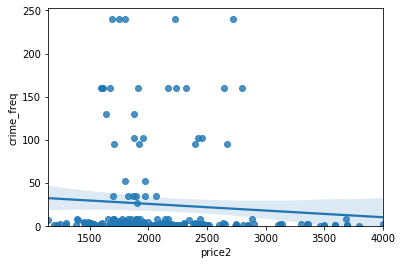

In [106]:
#run a quick correlation between price and frime frequency.
import matplotlib.pyplot as plt
import seaborn as sns
sns.regplot(x="price2", y="crime_freq", data=df_la_rent2)
plt.ylim(0,)

In [107]:
#run a correlation to see the relationship between price and crime frequency. 
df_la_rent2[["price2","crime_freq"]].corr() 

,price2,crime_freq
price2,1.000000,-0.079548
crime_freq,-0.079548,1.000000


In [115]:
#create new column to convert crime frequency into a categorical variable
df_la_rent2['crime_levels'] = pd.cut(df_la_rent2['crime_freq'], [-1, 2,8,300], labels=['low', 'moderate', 'high'])
df_la_rent2

,address,latitude,longitude,price,zipcode,crime_types,crime_freq,"(address1, address2)",address2,address3,price2,crime_levels
0,"Wren | 1230 S Olive St, Los Angeles, CA",34.038567,-118.262796,"$1,875",90015,"[BATTERY - SIMPLE ASSAULT, ATTEMPTED ROBBERY, ...",102.0,"1230 S Olive St, Los Angeles, CA",Wren | 1230 S Olive St,1230 S Olive St,1875.0,high
1,"Eastown | 6201 Hollywood Blvd, Los Angeles, CA",34.102260,-118.324800,"$1,705",90028,"[OTHER MISCELLANEOUS CRIME, THEFT PLAIN - PETT...",8.0,"6201 Hollywood Blvd, Los Angeles, CA",Eastown | 6201 Hollywood Blvd,6201 Hollywood Blvd,1705.0,moderate
2,"Cobalt | 10601 Washington Blvd, Culver City, CA",34.017442,-118.405222,"$2,446",90232,NaN,0.0,"10601 Washington Blvd, Culver City, CA",Cobalt | 10601 Washington Blvd,10601 Washington Blvd,2446.0,low
3,"The Avenue Hollywood | 1619 N La Brea Ave, Los...",34.100538,-118.345047,"$2,885",90028,"[OTHER MISCELLANEOUS CRIME, THEFT PLAIN - PETT...",8.0,"1619 N La Brea Ave, Los Angeles, CA",The Avenue Hollywood | 1619 N La Brea Ave,1619 N La Brea Ave,2885.0,moderate
4,"Alessio | 5700 W Centinela Ave, Los Angeles, CA",33.975480,-118.381095,"$1,967",90056,NaN,0.0,"5700 W Centinela Ave, Los Angeles, CA",Alessio | 5700 W Centinela Ave,5700 W Centinela Ave,1967.0,low
...,...,...,...,...,...,...,...,...,...,...,...,...
182,"Del Mor Apartments | 1551 Echo Park Ave, Los A...",34.081258,-118.254915,"$1,940",90026,"[ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAUL...",2.0,"1551 Echo Park Ave, Los Angeles, CA",Del Mor Apartments | 1551 Echo Park Ave,1551 Echo Park Ave,1940.0,low
183,"7733 Oakwood Ave, Los Angeles, CA",34.078205,-118.358034,"$2,850",90036,[BATTERY - SIMPLE ASSAULT],1.0,NaN,7733 Oakwood Ave,NaN,2850.0,low
184,"Toscana Apartments | 15736 Vanowen St, Lake Ba...",34.193370,-118.476241,"$1,644",91406,NaN,0.0,"15736 Vanowen St, Lake Balboa, CA",Toscana Apartments | 15736 Vanowen St,15736 Vanowen St,1644.0,low
185,"The Visconti | 1221 W 3rd St, Los Angeles, CA",34.057280,-118.258237,"$1,825",90071,"[OTHER MISCELLANEOUS CRIME, INTIMATE PARTNER -...",35.0,"1221 W 3rd St, Los Angeles, CA",The Visconti | 1221 W 3rd St,1221 W 3rd St,1825.0,high


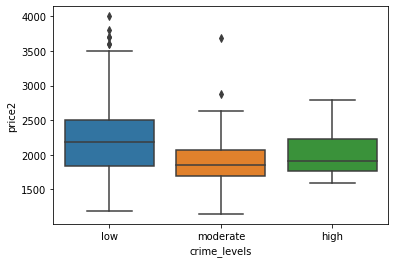

In [116]:
#create a boxplot to compare the levels of crime to the price.
sns.boxplot(x="crime_levels", y="price2", data=df_la_rent2)

## FINAL THOUGHTS 

The relationship between crime levels and price seems to be nelgible with a majority of low crimes seemed to be around $1900 and $2400, similar to moderate and high crimes. The range for low crimes seems to range widely from $1100 to $4000, suggesting that neighborhood locations were better predictors of crime levels then price point.  

Thus, if you are considering of finding a cheaper place that is safe, I would first suggesting picking anywhere NOT in Downtown LA and then search for a place with a reasonable pricing. The further West you move, the less the level of crimes. 